In [178]:
%reset
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
pd.set_option('display.precision', 3)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Opdracht 1: Exploratieve Data Analyse:
Gemaakt door de Majestueuze data-jokers:

&nbsp;&nbsp;&nbsp;&nbsp;Mark "Markolie20" Olieman <br>
&nbsp;&nbsp;&nbsp;&nbsp;Daan "Daan Eising" Eising <br>
&nbsp;&nbsp;&nbsp;&nbsp;Jesse "zdfgdfsg" van der Westen <br>

In [179]:
class EDA:
    def __init__(self, df):
        self.df = df
        
        self.feature_cols = self.df.columns.difference(["p_id", "Outcome"])
        self.target_col = "Outcome"
        self.zero_value_cols = ['Glucose', 'BMI', 'BloodPressure', 'SkinThickness']
        
        self.df_handler = DfHandler(df)
        self.vis = Visualizer()
        
        self.standardised_df = self.df_handler.standardise_df(self.feature_cols)
        
    def analyze_data(self, df):
        self.df_handler.display_stats(self.feature_cols)
        self.vis.box_dist_plots(self.df, self.feature_cols)
        self.vis.corr_heatmap(self.df_handler.get_corr(self.feature_cols, self.target_col))
    
    def clean_data(self):
        self.df = self.df_handler.clean_zero_values(self.zero_value_cols)
        self.df = self.df_handler.replaceWithKNN(self.df, ["Insulin"])
        self.standardised_df = self.df_handler.replaceWithKNN(self.df, ["Insulin"])
        
        

In [180]:
class Visualizer:
    def box_dist_plots(self, df, cols):
        fig, axes = plt.subplots(len(cols), 2, figsize=(10, 15))
        fig.tight_layout()    
        for index, col in enumerate(cols):
            sns.boxplot(x=df[col], ax=axes[index, 0])    
            sns.histplot(x=df[col], ax=axes[index, 1])
            
    def corr_heatmap(self, corr_df):
        fig = plt.figure(figsize=(5, 5))
        sns.heatmap(corr_df, annot=True)
        
    

In [181]:
class DfHandler:
    def __init__(self, df):
        self.df = df
        
    def display_stats(self, cols):
        stats = self.df[cols].describe().T
        stats['dtype'] = [self.df[col].dtype for col in cols]
        display(stats)
        
    def clean_zero_values(self, columns):
        for col in columns:
            self.df = self.df.drop(self.df.loc[(df[col] == 0)].index)
            
        return self.df
    
    def get_corr(self, feature_cols, target_col):
        corr = pd.DataFrame(self.df[feature_cols].corrwith(self.df[target_col], method='pearson'))
        corr = corr.sort_values(0, ascending=False)
        return corr
            
    def standardise_df(self, cols):
        scaler = StandardScaler()
        self.df[cols] = pd.DataFrame(scaler.fit_transform(self.df[cols]), 
                                                     index=self.df[cols].index, 
                                                     columns=self.df[cols].columns)
        self.df = df
        
        return self.df
    
    def replaceWithKNN(self, df, cols):
        knnImputer = KNNImputer()
        df[cols] = df[cols].replace(0, np.NaN)
        df = pd.DataFrame(knnImputer.fit_transform(df), columns=df.columns)
        
        return df

In [182]:
df = pd.read_csv("train_c.csv")
eda = EDA(df)

## Data bekijken
De eerste stap die wij volgen is het bekijken van de verdelingen van de data, dit doen we door de basisstatistieken van alle feature kolommen te bekijken. 
we bekijken volgende statistieken:
- Gemiddelde
- Mediaan
- Standaard deviatie
- Min- en Maximum
- Eerste en derde kwartiel


Ook plotten wij van elke feature kolom de boxplot en een histogram om te kijken hoe de waardes verdeeld zijn in de dataset. Hiermee kunnen wij zien of er data in de dataset zit die wellicht niet juist is of dat er wellicht een hoop uitschieters zijn. 
Ook kunnen we zien of de data normaal verdeeld is of niet en of er eigenaardigheden zijn.

Als laatst gaan wij ook alvast kijken welke correlaties er zijn tussen de feature kolommen en de target kolom, hiermee kunnen we alvast een beeld schetsen over hoe de feature kolommen de target kolom kunnen beschrijven.

,count,mean,std,min,25%,50%,75%,max,dtype
Age,614.0,-2.936e-16,1.001,-1.036,-0.782,-0.360,0.653,3.271,float64
BMI,614.0,-4.050e-16,1.001,-3.927,-0.557,0.027,0.562,4.326,float64
BloodPressure,614.0,-2.691e-16,1.001,-3.460,-0.347,0.155,0.557,2.264,float64
DiabetesPedigreeFunction,614.0,-2.893e-18,1.001,-1.186,-0.700,-0.312,0.488,5.934,float64
Glucose,614.0,-1.562e-16,1.001,-3.772,-0.672,-0.171,0.612,2.397,float64
Insulin,614.0,2.025e-17,1.001,-0.695,-0.695,-0.464,0.417,5.672,float64
Pregnancies,614.0,-2.314e-17,1.001,-1.129,-0.833,-0.240,0.649,3.318,float64
SkinThickness,614.0,1.157e-16,1.001,-1.275,-1.275,0.159,0.719,4.894,float64


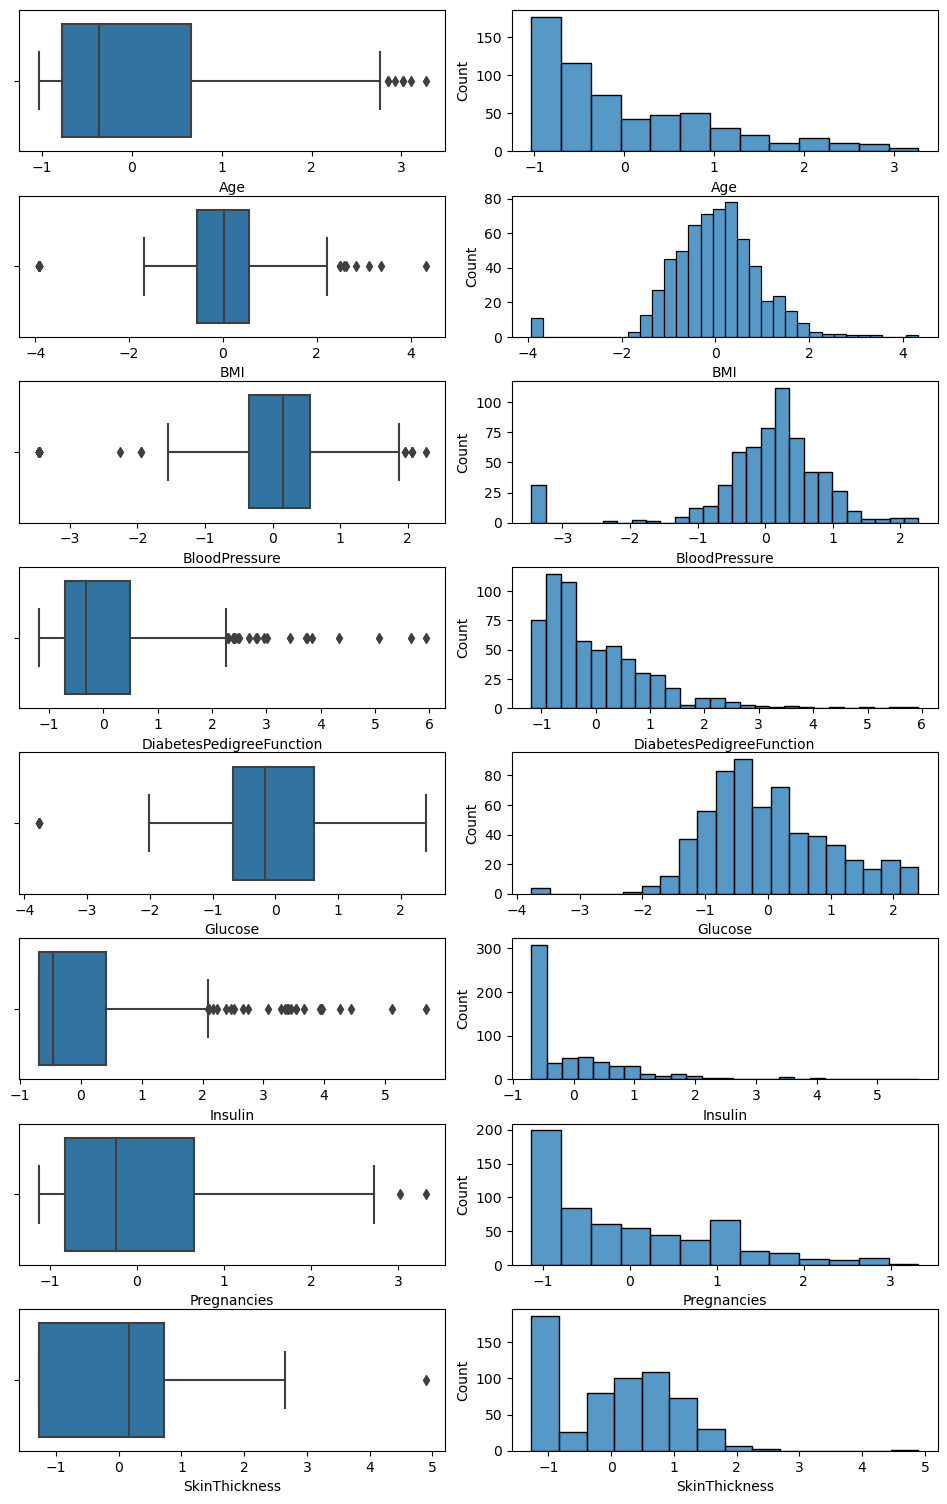

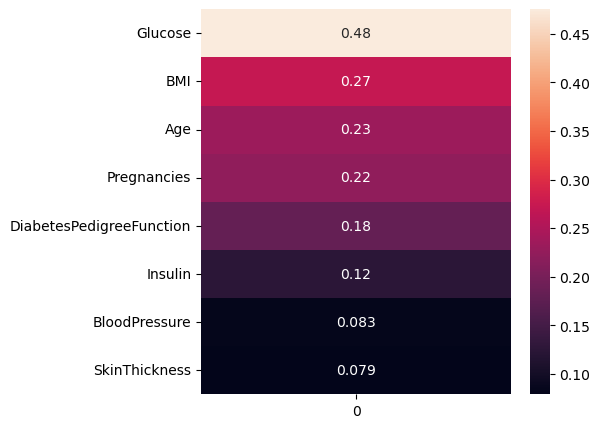

In [183]:
eda.analyze_data(eda.df)

## Voldoet de data aan de voorwaarden voor machine learning?
De data voldoet aan de voorwaarden aangezien de data:
- In een dataframe staat
- Geen lege waardes bevat
- In numerieke waardes is beschreven

## Data opschonen
Echter vinden wij dat de data nog schoongemaakt kan worden, dit vinden wij omdat in de boxplots te zien valt dat de volgende kolommen nog waardes van 0 bevatten die niet mogelijk zouden moeten zijn.
- Glucose
- BMI
- BloodPressure
- Insulin
- SkinThickness

Deze waardes met 0 gaan wij uit de data verwijderen.

Ook zien we dat er veel uitschieters zijn, wij vinden het belangrijk om deze data alsnog mee te nemen aangezien wij denken dat dit wellicht komt door omstandigheden die ook kunnen bijdragen aan diabetes.

,count,mean,std,min,25%,50%,75%,max,dtype
Age,614.0,-2.936e-16,1.001,-1.036,-0.782,-0.360,0.653,3.271,float64
BMI,614.0,-4.050e-16,1.001,-3.927,-0.557,0.027,0.562,4.326,float64
BloodPressure,614.0,-2.691e-16,1.001,-3.460,-0.347,0.155,0.557,2.264,float64
DiabetesPedigreeFunction,614.0,-2.893e-18,1.001,-1.186,-0.700,-0.312,0.488,5.934,float64
Glucose,614.0,-1.562e-16,1.001,-3.772,-0.672,-0.171,0.612,2.397,float64
Insulin,614.0,2.025e-17,1.001,-0.695,-0.695,-0.464,0.417,5.672,float64
Pregnancies,614.0,-2.314e-17,1.001,-1.129,-0.833,-0.240,0.649,3.318,float64
SkinThickness,614.0,1.157e-16,1.001,-1.275,-1.275,0.159,0.719,4.894,float64


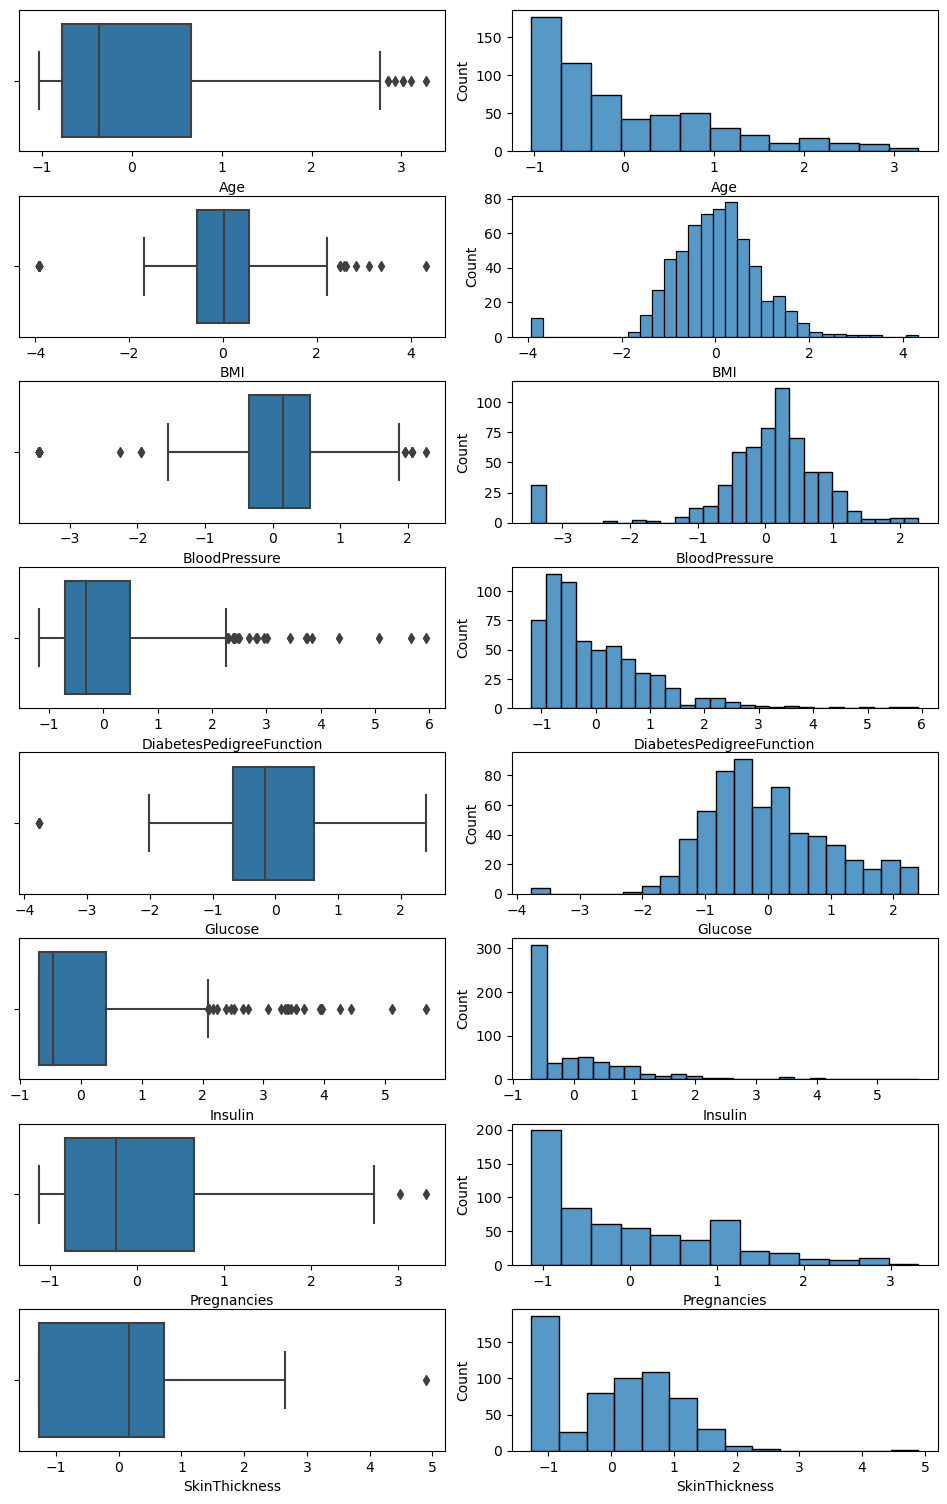

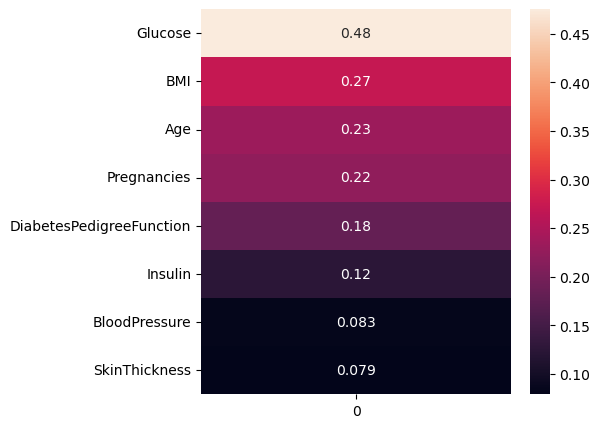

In [176]:
eda.clean_data()
eda.analyze_data(eda.df)

## Opvallende dingen over opgeschoonde data
We zien dat de data van 614 rijen naar 312 rijen is gegaan, dit betekent dat wij een hoop rijen hebben verwijderd. Echter vinden wij dat dit beter is dan het alternatief, aangezien wij geen vertrouwen hebben goede modellen te kunnen maken als we geen goede data invoeren in de modellen. Zoals het beroemde gezegde "Garbage in = garbage out". 

We zien ook dat de correlaties omhoog zijn gegaan en dit is een goede indicatie dat de data die nu verwijderd is geen goede weergave gaf van de realiteit.

## Standardiseren:
### wat is standaardiseren:
standaardiseren houdt in dat je de feature kolommen zo schaalt dat het gemiddelde op 0 komt te staan en de standaard deviatie op 1. 

In [78]:
eda.standardise_df()
eda.display_stats(eda.standardised_df)

,count,mean,std,min,25%,50%,75%,max,dtype
Age,312.0,-1.879e-16,1.002,-0.968,-0.764,-0.357,0.482,3.305,float64
BMI,312.0,5.693e-17,1.002,-2.107,-0.675,-0.003,0.516,4.707,float64
BloodPressure,312.0,3.815e-16,1.002,-3.712,-0.716,0.072,0.703,3.068,float64
DiabetesPedigreeFunction,312.0,-1.025e-16,1.002,-1.245,-0.736,-0.195,0.485,5.508,float64
Glucose,312.0,-9.964e-17,1.002,-2.173,-0.764,-0.109,0.686,2.447,float64
Insulin,312.0,-5.266e-17,1.002,-1.214,-0.672,-0.271,0.281,4.873,float64
Pregnancies,312.0,9.110e-17,1.002,-0.998,-0.685,-0.371,0.256,3.707,float64
SkinThickness,312.0,1.196e-16,1.002,-2.128,-0.796,-0.034,0.727,3.202,float64
